In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

## 1. Load Data

In [2]:
# Load owned games data (with genres from Store API)
try:
    owned_games = pd.read_csv('../data/owned_games_enriched.csv')
    print(f"✅ Loaded {len(owned_games)} owned games")
    print(f"Columns: {list(owned_games.columns)}")
    display(owned_games.head(3))
except FileNotFoundError:
    print("❌ Error: Run src/data_collection.py first to collect your Steam data")
    owned_games = pd.DataFrame()

# Load Steam catalog (with genres AND tags from SteamSpy)
try:
    steam_catalog = pd.read_csv('../data/steam_catalog_detailed.csv')
    print(f"\n✅ Loaded {len(steam_catalog)} games from Steam catalog")
    print(f"Columns: {list(steam_catalog.columns)}")
    display(steam_catalog.head(3))
except FileNotFoundError:
    print("❌ Error: Run src/get_detailed_catalog.py to get Steam catalog")
    steam_catalog = pd.DataFrame()

✅ Loaded 67 owned games
Columns: ['appid', 'name', 'playtime_forever', 'img_icon_url', 'playtime_windows_forever', 'playtime_mac_forever', 'playtime_linux_forever', 'playtime_deck_forever', 'rtime_last_played', 'content_descriptorids', 'playtime_disconnected', 'has_community_visible_stats', 'playtime_2weeks', 'has_leaderboards', 'playtime_hours', 'type', 'short_description', 'detailed_description', 'developers', 'publishers', 'genres', 'categories', 'release_date', 'metacritic_score', 'recommendations', 'price_overview', 'platforms', 'review_score', 'review_score_desc', 'total_positive', 'total_negative', 'total_reviews']


,appid,name,playtime_forever,img_icon_url,playtime_windows_forever,playtime_mac_forever,playtime_linux_forever,playtime_deck_forever,rtime_last_played,content_descriptorids,playtime_disconnected,has_community_visible_stats,playtime_2weeks,has_leaderboards,playtime_hours,type,short_description,detailed_description,developers,publishers,genres,categories,release_date,metacritic_score,recommendations,price_overview,platforms,review_score,review_score_desc,total_positive,total_negative,total_reviews
0,70,Half-Life,213,95be6d131fc61f145797317ca437c9765f24b41c,213,0,0,0,1581484397,"[2, 5]",0,NaN,NaN,NaN,3.55,game,Named Game of the Year by over 50 publications...,Named Game of the Year by over 50 publications...,['Valve'],['Valve'],['Action'],"['Single-player', 'Multi-player', 'PvP', 'Onli...","19 Nov, 1998",96.0,109557.0,"{'currency': 'GBP', 'initial': 719, 'final': 7...","{'windows': True, 'mac': True, 'linux': True}",9,Overwhelmingly Positive,53058,1924,54982
1,220,Half-Life 2,0,fcfb366051782b8ebf2aa297f3b746395858cb62,0,0,0,0,0,"[2, 5]",0,True,NaN,NaN,0.00,game,Reawakened from stasis in the occupied metropo...,"<p class=""bb_paragraph"" ><i>The Seven Hour War...",['Valve'],['Valve'],['Action'],"['Single-player', 'Steam Achievements', 'Full ...","Nov 16, 2004",96.0,189460.0,"{'currency': 'USD', 'initial': 999, 'final': 9...","{'windows': True, 'mac': False, 'linux': True}",9,Overwhelmingly Positive,82782,2217,84999
2,320,Half-Life 2: Deathmatch,0,795e85364189511f4990861b578084deef086cb1,0,0,0,0,0,"[2, 5]",0,NaN,NaN,NaN,0.00,game,Fast multiplayer action set in the Half-Life 2...,Fast multiplayer action set in the Half-Life 2...,['Valve'],['Valve'],['Action'],"['Multi-player', 'Custom Volume Controls', 'Pl...","Nov 1, 2004",NaN,9855.0,{},"{'windows': True, 'mac': False, 'linux': True}",8,Very Positive,4046,452,4498



✅ Loaded 86542 games from Steam catalog
Columns: ['appid', 'name', 'developer', 'publisher', 'score_rank', 'owners', 'average_forever', 'average_2weeks', 'median_forever', 'median_2weeks', 'positive', 'negative', 'userscore', 'ccu', 'price', 'initialprice', 'discount', 'tags', 'languages', 'genre']


,appid,name,developer,publisher,score_rank,owners,average_forever,average_2weeks,median_forever,median_2weeks,positive,negative,userscore,ccu,price,initialprice,discount,tags,languages,genre
0,1172470,Apex Legends,Respawn,Electronic Arts,NaN,"100,000,000 .. 200,000,000",10035,556,904,235,668053,326926,0,124262,0.0,0.0,0.0,"{""Free to Play"": 2232, ""Battle Royale"": 1511, ...","English, French, Italian, German, Spanish - Sp...","Action, Adventure, Free To Play"
1,252490,Rust,Facepunch Studios,Facepunch Studios,NaN,"20,000,000 .. 50,000,000",26694,1311,3437,391,1071135,156649,0,143870,1999.0,3999.0,50.0,"{""Survival"": 18782, ""Crafting"": 11939, ""Multip...","English, French, Italian, German, Spanish - Sp...","Action, Adventure, Indie, Massively Multiplaye..."
2,4000,Garry's Mod,Facepunch Studios,Valve,NaN,"20,000,000 .. 50,000,000",9916,840,1280,162,1122546,37161,0,18400,999.0,999.0,0.0,"{""Sandbox"": 18787, ""Moddable"": 14544, ""Multipl...","English, French, Italian, German, Spanish - Sp...","Casual, Indie, Simulation"


## 2. Data Exploration

## 1.5. Parse Genre and Tag Data

Genres and tags are stored as strings/JSON - we need to parse them for analysis

In [3]:
import json
import ast

def parse_genres(genres_str):
    """Parse genres from owned_games (list format like ['Action', 'RPG'])"""
    if pd.isna(genres_str) or genres_str == '[]':
        return []
    try:
        # Try parsing as list
        return ast.literal_eval(genres_str) if isinstance(genres_str, str) else genres_str
    except:
        # Fallback: split by comma
        return [g.strip() for g in str(genres_str).split(',') if g.strip()]

def parse_tags(tags_str):
    """Parse tags from catalog (JSON dict like {"FPS": 1234, "Shooter": 567})"""
    if pd.isna(tags_str) or tags_str == '{}':
        return {}
    try:
        return json.loads(tags_str) if isinstance(tags_str, str) else tags_str
    except:
        return {}

def parse_catalog_genre(genre_str):
    """Parse genre from catalog (comma-separated like 'Action, RPG')"""
    if pd.isna(genre_str) or genre_str == '':
        return []
    return [g.strip() for g in str(genre_str).split(',') if g.strip()]

# Parse owned games genres
if not owned_games.empty and 'genres' in owned_games.columns:
    owned_games['genres_list'] = owned_games['genres'].apply(parse_genres)
    print("✅ Parsed owned games genres")
    print(f"Example: {owned_games['genres_list'].iloc[0] if len(owned_games) > 0 else 'N/A'}")

# Parse catalog genres and tags
if not steam_catalog.empty:
    if 'genre' in steam_catalog.columns:
        steam_catalog['genres_list'] = steam_catalog['genre'].apply(parse_catalog_genre)
        print("\n✅ Parsed catalog genres")
    
    if 'tags' in steam_catalog.columns:
        steam_catalog['tags_dict'] = steam_catalog['tags'].apply(parse_tags)
        steam_catalog['top_tags'] = steam_catalog['tags_dict'].apply(
            lambda x: list(x.keys())[:5] if x else []
        )
        print("✅ Parsed catalog tags")
        print(f"Example tags: {steam_catalog['top_tags'].iloc[0] if len(steam_catalog) > 0 else 'N/A'}")

✅ Parsed owned games genres
Example: ['Action']

✅ Parsed catalog genres
✅ Parsed catalog tags
Example tags: ['Free to Play', 'Battle Royale', 'Multiplayer', 'FPS', 'Shooter']


In [4]:
if not owned_games.empty:
    print("=" * 60)
    print("YOUR GAMING LIBRARY ANALYSIS")
    print("=" * 60)
    print("\n📊 Dataset Info:")
    print(f"Total games owned: {len(owned_games)}")
    print(f"Total playtime: {owned_games['playtime_forever'].sum() / 60:.1f} hours")
    print(f"\nColumns available: {list(owned_games.columns)}")
    
    # Genre analysis
    if 'genres_list' in owned_games.columns:
        all_genres = []
        for genres in owned_games['genres_list']:
            all_genres.extend(genres)
        
        genre_counts = pd.Series(all_genres).value_counts()
        print(f"\n🎮 Your Top Genres (by game count):")
        print(genre_counts.head(10))
        
        # Genre weighted by playtime
        genre_playtime = {}
        for idx, row in owned_games.iterrows():
            playtime = row['playtime_forever'] / 60  # Convert to hours
            for genre in row['genres_list']:
                genre_playtime[genre] = genre_playtime.get(genre, 0) + playtime
        
        genre_playtime_series = pd.Series(genre_playtime).sort_values(ascending=False)
        print(f"\n⏱️  Your Top Genres (by playtime hours):")
        print(genre_playtime_series.head(10))

YOUR GAMING LIBRARY ANALYSIS

📊 Dataset Info:
Total games owned: 67
Total playtime: 2549.3 hours

Columns available: ['appid', 'name', 'playtime_forever', 'img_icon_url', 'playtime_windows_forever', 'playtime_mac_forever', 'playtime_linux_forever', 'playtime_deck_forever', 'rtime_last_played', 'content_descriptorids', 'playtime_disconnected', 'has_community_visible_stats', 'playtime_2weeks', 'has_leaderboards', 'playtime_hours', 'type', 'short_description', 'detailed_description', 'developers', 'publishers', 'genres', 'categories', 'release_date', 'metacritic_score', 'recommendations', 'price_overview', 'platforms', 'review_score', 'review_score_desc', 'total_positive', 'total_negative', 'total_reviews', 'genres_list']

🎮 Your Top Genres (by game count):
Action                   53
Adventure                22
RPG                      16
Indie                    16
Strategy                  6
Free To Play              6
Early Access              5
Simulation                4
Casual     

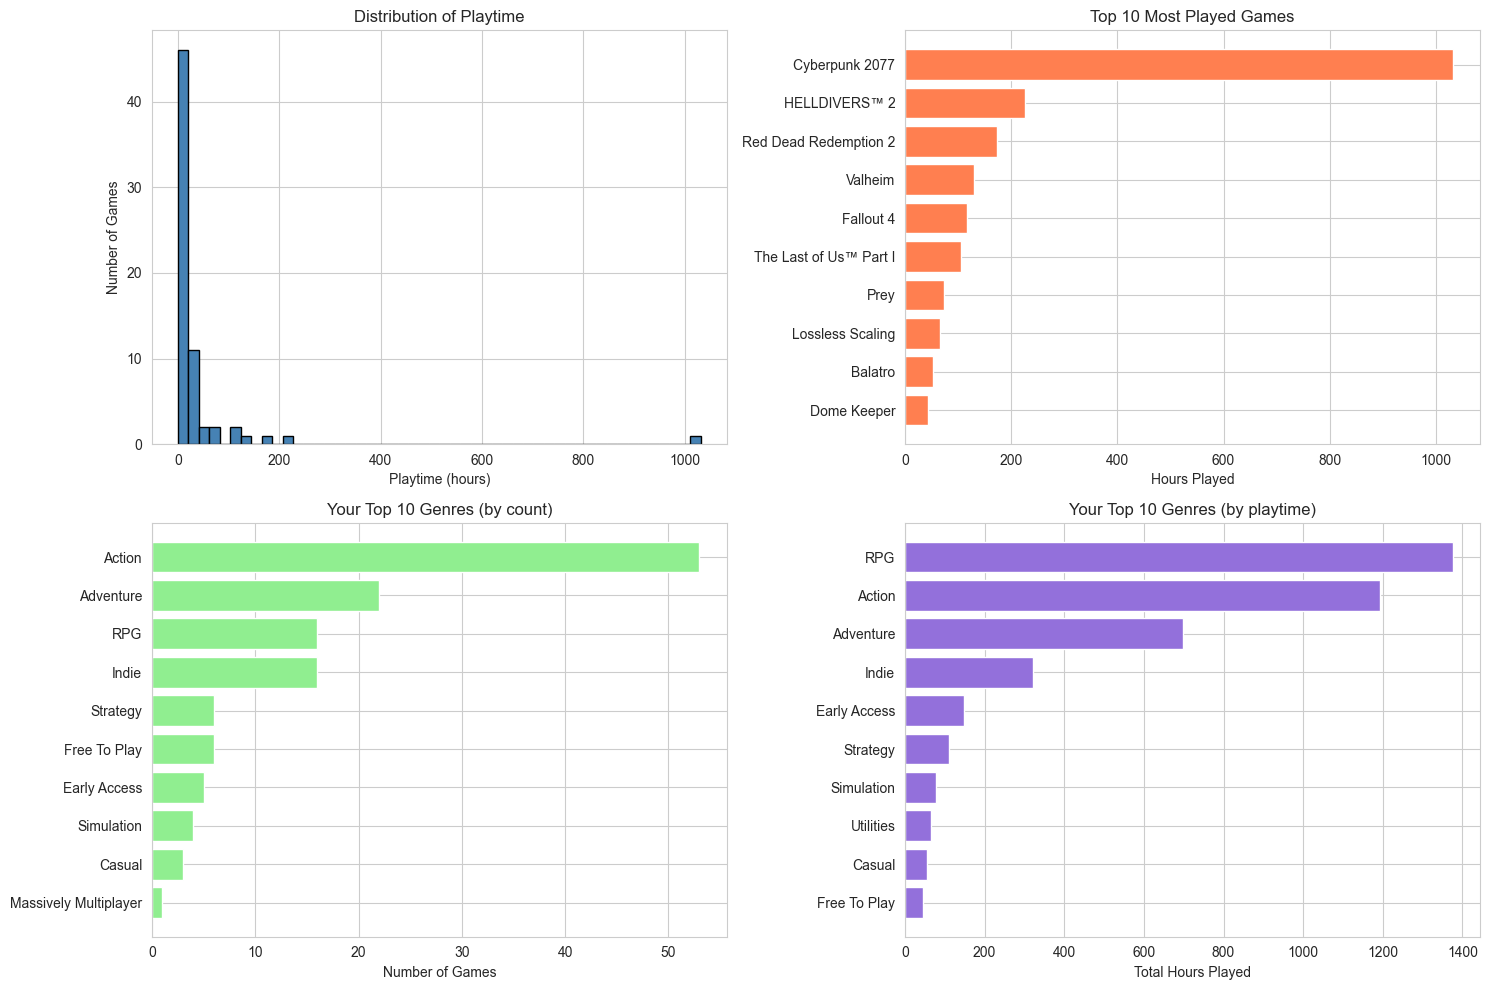

In [5]:
# Visualize playtime and genre distribution
if not owned_games.empty and 'playtime_hours' in owned_games.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Playtime distribution
    axes[0, 0].hist(owned_games['playtime_hours'], bins=50, edgecolor='black', color='steelblue')
    axes[0, 0].set_xlabel('Playtime (hours)')
    axes[0, 0].set_ylabel('Number of Games')
    axes[0, 0].set_title('Distribution of Playtime')
    
    # Top 10 most played
    top_played = owned_games.nlargest(10, 'playtime_hours')
    axes[0, 1].barh(top_played['name'], top_played['playtime_hours'], color='coral')
    axes[0, 1].set_xlabel('Hours Played')
    axes[0, 1].set_title('Top 10 Most Played Games')
    axes[0, 1].invert_yaxis()
    
    # Genre distribution by game count
    if 'genres_list' in owned_games.columns:
        all_genres = []
        for genres in owned_games['genres_list']:
            all_genres.extend(genres)
        genre_counts = pd.Series(all_genres).value_counts().head(10)
        
        axes[1, 0].barh(genre_counts.index, genre_counts.values, color='lightgreen')
        axes[1, 0].set_xlabel('Number of Games')
        axes[1, 0].set_title('Your Top 10 Genres (by count)')
        axes[1, 0].invert_yaxis()
        
        # Genre distribution by playtime
        genre_playtime = {}
        for idx, row in owned_games.iterrows():
            playtime = row['playtime_forever'] / 60
            for genre in row['genres_list']:
                genre_playtime[genre] = genre_playtime.get(genre, 0) + playtime
        
        genre_playtime_series = pd.Series(genre_playtime).sort_values(ascending=False).head(10)
        axes[1, 1].barh(genre_playtime_series.index, genre_playtime_series.values, color='mediumpurple')
        axes[1, 1].set_xlabel('Total Hours Played')
        axes[1, 1].set_title('Your Top 10 Genres (by playtime)')
        axes[1, 1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

## 3. Feature Engineering

Create features that indicate game preferences:
- Playtime categories (unplayed, tried, played, loved)
- Engagement score based on playtime

In [6]:
if not owned_games.empty:
    # Create playtime categories
    def categorize_playtime(hours):
        if hours == 0:
            return 'unplayed'
        elif hours < 5:
            return 'tried'
        elif hours < 50:
            return 'played'
        else:
            return 'loved'
    
    owned_games['playtime_category'] = owned_games['playtime_hours'].apply(categorize_playtime)
    
    # Calculate engagement score (normalized playtime)
    max_playtime = owned_games['playtime_hours'].max()
    owned_games['engagement_score'] = owned_games['playtime_hours'] / max_playtime if max_playtime > 0 else 0
    
    print("📊 Playtime categories:")
    print(owned_games['playtime_category'].value_counts())
    
    # Extract preference profile from "loved" games (50+ hours)
    loved_games = owned_games[owned_games['playtime_category'] == 'loved']
    print(f"\n❤️  Your 'loved' games (50+ hours): {len(loved_games)}")
    
    if len(loved_games) > 0 and 'genres_list' in loved_games.columns:
        # Calculate genre preferences from loved games
        loved_genres = []
        for genres in loved_games['genres_list']:
            loved_genres.extend(genres)
        
        genre_preference = pd.Series(loved_genres).value_counts()
        print(f"\n🎯 Genres you LOVE (from 50+ hour games):")
        print(genre_preference.head(10))
        
        # Store for recommendation system
        owned_games['genre_preference_score'] = owned_games['genres_list'].apply(
            lambda genres: sum(genre_preference.get(g, 0) for g in genres)
        )

📊 Playtime categories:
playtime_category
played      25
tried       24
unplayed     9
loved        9
Name: count, dtype: int64

❤️  Your 'loved' games (50+ hours): 9

🎯 Genres you LOVE (from 50+ hour games):
Action          5
Adventure       4
RPG             3
Indie           2
Early Access    1
Utilities       1
Casual          1
Strategy        1
Name: count, dtype: int64


## 4. Simple Recommendation System

Start with a content-based approach using playtime as the main signal.
Later, this can be enhanced with game genres, tags, and features.

In [ ]:
def get_top_games(df, n=10):
    """Get user's most played games"""
    return df.nlargest(n, 'playtime_hours')[['name', 'playtime_hours', 'engagement_score']]

if not owned_games.empty:
    print("Your top games:")
    print(get_top_games(owned_games))

## 5. Build Recommendation System

Now we have all the data we need:
- **Your library**: Playtime + genres from Store API
- **Steam catalog**: 81k+ games with genres + tags from SteamSpy

**Recommendation Strategy**:
1. Analyze your "loved" games (50+ hours) to understand preferences
2. Extract genre patterns and tag preferences
3. Find games in catalog you don't own that match your taste
4. Rank by similarity to your loved games

In [ ]:
# Build recommendation system using genres and tags
class GameRecommender:
    def __init__(self, user_games, catalog):
        self.user_games = user_games
        self.catalog = catalog
        self.user_profile = None
        self.owned_appids = set(user_games['appid'].astype(str))
        
        # NSFW content filter - tags to exclude by default
        self.nsfw_tags = {
            'Sexual Content', 'Nudity', 'NSFW', 'Adult',
            'Hentai', 'Erotic', 'Sexual', 'Porn', '18+', 'Adult Only'
        }
        
        # Non-gameplay genres (business model / development stage, not gameplay)
        # Can be optionally excluded from matching to focus on actual gameplay
        self.meta_genres = {
            'Indie', 'Casual', 'Early Access', 'Free to Play', 
            'Massively Multiplayer'  # Too broad - could be MMO RPG, MMO shooter, etc.
        }
    
    def build_user_profile(self, include_meta_genres=False):
        """Analyze user's loved games to build preference profile
        
        Args:
            include_meta_genres: If True, include Indie/Casual/etc. in matching
                                 If False, focus only on gameplay genres (default)
        """
        loved_games = self.user_games[self.user_games['playtime_category'] == 'loved']
        
        if len(loved_games) == 0:
            print("⚠️  No 'loved' games found (50+ hours). Using all played games.")
            loved_games = self.user_games[self.user_games['playtime_hours'] > 0]
        
        # Genre preferences (weighted by playtime)
        genre_scores = {}
        for idx, game in loved_games.iterrows():
            playtime = game['playtime_forever'] / 60
            for genre in game['genres_list']:
                # Skip meta genres unless explicitly requested
                if not include_meta_genres and genre in self.meta_genres:
                    continue
                genre_scores[genre] = genre_scores.get(genre, 0) + playtime
        
        self.user_profile = {
            'loved_games': len(loved_games),
            'top_genres': pd.Series(genre_scores).sort_values(ascending=False).head(10).to_dict(),
            'total_playtime': loved_games['playtime_forever'].sum() / 60,
            'include_meta_genres': include_meta_genres
        }
        
        print("🎯 User Profile Built!")
        print(f"Loved games: {self.user_profile['loved_games']}")
        genre_type = "all genres" if include_meta_genres else "gameplay genres only"
        print(f"Top genres ({genre_type}): {list(self.user_profile['top_genres'].keys())[:5]}")
        
        return self.user_profile
    
    def is_sfw_game(self, game):
        """Check if game is safe for work (no NSFW tags)"""
        game_tags = game.get('top_tags', [])
        if not game_tags:
            return True  # No tags means we can't filter it, allow by default
        
        # Check if any NSFW tags are present
        for tag in game_tags:
            if tag in self.nsfw_tags:
                return False
        return True
    
    def calculate_review_quality_score(self, positive, negative):
        """Calculate quality score based on review percentage and volume"""
        total_reviews = positive + negative
        if total_reviews == 0:
            return 0
        
        review_percentage = (positive / total_reviews) * 100
        
        # Quality tiers
        if review_percentage >= 95:
            quality_multiplier = 2.5  # Overwhelmingly Positive
        elif review_percentage >= 90:
            quality_multiplier = 2.0  # Very Positive
        elif review_percentage >= 80:
            quality_multiplier = 1.5  # Mostly Positive
        elif review_percentage >= 70:
            quality_multiplier = 1.0  # Positive
        elif review_percentage >= 60:
            quality_multiplier = 0.5  # Mixed (penalize)
        else:
            quality_multiplier = 0.1  # Negative/Mostly Negative (heavy penalty)
        
        # Volume bonus (logarithmic - more reviews = more reliable)
        volume_score = np.log10(total_reviews + 1) * quality_multiplier
        
        return volume_score
    
    def calculate_similarity(self, catalog_game):
        """Calculate similarity score between catalog game and user preferences"""
        if not self.user_profile:
            return 0
        
        score = 0
        include_meta = self.user_profile.get('include_meta_genres', False)
        
        # 1. Genre matching (40% weight)
        game_genres = catalog_game.get('genres_list', [])
        genre_match_score = 0
        for genre in game_genres:
            # Skip meta genres unless user wants them included
            if not include_meta and genre in self.meta_genres:
                continue
            # Match on genres in user's profile
            if genre in self.user_profile['top_genres']:
                genre_match_score += self.user_profile['top_genres'][genre] * 0.4
        score += genre_match_score
        
        # 2. Review quality score (40% weight)
        positive = catalog_game.get('positive', 0)
        negative = catalog_game.get('negative', 0)
        quality_score = self.calculate_review_quality_score(positive, negative)
        score += quality_score * 40  # Scale up quality impact
        
        # 3. Engagement quality - median playtime (20% weight)
        median_playtime = catalog_game.get('median_forever', 0)
        if median_playtime > 0:
            median_hours = median_playtime / 60
            # Games with high median playtime = players actually enjoy them
            if median_hours >= 50:
                score += 50  # Deep, engaging game
            elif median_hours >= 20:
                score += 30  # Good engagement
            elif median_hours >= 10:
                score += 15  # Decent engagement
            elif median_hours >= 5:
                score += 5   # Some engagement
            # Games with <5 hour median might not be engaging enough
        
        return score
    
    def recommend(self, n=20, min_reviews=500, min_review_score=70, sfw_only=True, 
                  exclude_early_access=True, include_meta_genres=False):
        """Generate top N recommendations
        
        Args:
            n: Number of recommendations to return
            min_reviews: Minimum positive reviews required
            min_review_score: Minimum review percentage (default 70% = "Positive" or better)
            sfw_only: If True, filter out NSFW content (default: True)
            exclude_early_access: If True, filter out Early Access games (default: True)
            include_meta_genres: If True, match on Indie/Casual/F2P/etc. (default: False)
                                 Set to True if you specifically want indie or casual games
        """
        if not self.user_profile or self.user_profile.get('include_meta_genres') != include_meta_genres:
            self.build_user_profile(include_meta_genres=include_meta_genres)
        
        print(f"\n🔍 Searching {len(self.catalog)} games for recommendations...")
        if sfw_only:
            print("🔒 SFW Filter: ON (excluding mature/sexual content)")
        if exclude_early_access:
            print("🚧 Excluding Early Access games (showing finished games only)")
        print(f"⭐ Minimum review score: {min_review_score}%")
        
        if include_meta_genres:
            print(f"🎮 Matching on ALL genres (including Indie/Casual/F2P/etc.)")
        else:
            print(f"🎮 Matching on gameplay genres only (ignoring Indie/Casual/etc.)")
        
        # Filter: games not owned, with minimum reviews, and genres available
        candidates = self.catalog[
            (~self.catalog['appid'].astype(str).isin(self.owned_appids)) &
            (self.catalog['positive'] >= min_reviews) &
            (self.catalog['genres_list'].apply(len) > 0)
        ].copy()
        
        # Apply review quality filter
        candidates['review_percentage'] = (
            candidates['positive'] / (candidates['positive'] + candidates['negative']) * 100
        )
        before_review_filter = len(candidates)
        candidates = candidates[candidates['review_percentage'] >= min_review_score]
        print(f"⭐ Filtered out {before_review_filter - len(candidates)} low-rated games (<{min_review_score}%)")
        
        # Apply Early Access filter
        if exclude_early_access:
            if 'genres_list' in candidates.columns:
                before_ea_filter = len(candidates)
                candidates = candidates[
                    ~candidates['genres_list'].apply(lambda x: 'Early Access' in x)
                ]
                print(f"🚧 Filtered out {before_ea_filter - len(candidates)} Early Access games")
        
        # Apply SFW filter if enabled
        if sfw_only:
            before_filter = len(candidates)
            candidates = candidates[candidates.apply(self.is_sfw_game, axis=1)]
            filtered_count = before_filter - len(candidates)
            print(f"🔒 Filtered out {filtered_count} NSFW games")
        
        print(f"📋 {len(candidates)} candidate games after filtering")
        
        # Calculate similarity scores
        candidates['similarity_score'] = candidates.apply(
            lambda row: self.calculate_similarity(row), axis=1
        )
        
        # Get top recommendations
        recommendations = candidates.nlargest(n, 'similarity_score')[
            ['appid', 'name', 'developer', 'publisher', 'genres_list', 'top_tags',
             'positive', 'negative', 'review_percentage', 'owners', 'median_forever', 
             'languages', 'price', 'initialprice', 'discount', 'similarity_score']
        ]
        
        return recommendations

# Initialize recommender
if not owned_games.empty and not steam_catalog.empty:
    print("="*60)
    print("BUILDING RECOMMENDATION SYSTEM")
    print("="*60)
    
    recommender = GameRecommender(owned_games, steam_catalog)
    
    # Generate recommendations with quality filters
    # - SFW by default
    # - Exclude Early Access (you can change to False if you want EA games)
    # - Minimum 70% positive reviews (you can adjust: 80 for "Mostly Positive", 90 for "Very Positive")
    # - include_meta_genres=False (default: focus on gameplay genres like RPG, Action, etc.)
    #   Set to True if you specifically want to find indie or casual games
    print("\n" + "="*60)
    print("TOP 20 RECOMMENDED GAMES FOR YOU")
    print("="*60)
    recommendations = recommender.recommend(
        n=20, 
        sfw_only=True, 
        exclude_early_access=True,       # False to include Early Access
        min_review_score=70,              # 80 or 90 for higher quality
        include_meta_genres=False         # True to match on Indie/Casual/F2P/etc.
    )
    
    # Display recommendations with rich details
    for i, (idx, game) in enumerate(recommendations.iterrows(), 1):
        print(f"\n{'='*70}")
        print(f"#{i}. {game['name']}")
        print(f"{'='*70}")
        
        # Genres
        genres = game['genres_list'][:5] if len(game['genres_list']) > 5 else game['genres_list']
        print(f"🎮 Genres: {', '.join(genres)}")
        
        # Tags (top community tags)
        if game['top_tags'] and len(game['top_tags']) > 0:
            tags = game['top_tags'][:8]  # Show top 8 tags
            print(f"🏷️  Tags: {', '.join(tags)}")
        
        # Developer & Publisher
        if pd.notna(game['developer']):
            print(f"👨‍💻 Developer: {game['developer']}")
        if pd.notna(game['publisher']) and game['publisher'] != game['developer']:
            print(f"📦 Publisher: {game['publisher']}")
        
        # Review stats with percentage
        total_reviews = game['positive'] + game['negative']
        review_pct = game['review_percentage']
        print(f"⭐ Reviews: {review_pct:.1f}% positive ({game['positive']:,} 👍 / {game['negative']:,} 👎)")
        
        # Player metrics
        print(f"👥 Owners: {game['owners']}")
        if pd.notna(game['median_forever']) and game['median_forever'] > 0:
            median_hours = game['median_forever'] / 60
            print(f"⏱️  Median Playtime: {median_hours:.1f} hours")
        
        # Languages
        if pd.notna(game['languages']):
            lang_count = len([l.strip() for l in str(game['languages']).split(',') if l.strip()])
            print(f"🌍 Languages: {lang_count} supported")
        
        # Price & Discount
        price = int(game['price']) / 100 if pd.notna(game['price']) and game['price'] != '0' else 0
        if price > 0:
            if pd.notna(game['discount']) and game['discount'] > 0:
                original = int(game['initialprice']) / 100 if pd.notna(game['initialprice']) else price
                print(f"💰 Price: ${price:.2f} (🔥 {int(game['discount'])}% OFF - was ${original:.2f})")
            else:
                print(f"💰 Price: ${price:.2f}")
        else:
            print(f"💰 Price: Free to Play")
        
        # Match score
        print(f"🎯 Match Score: {game['similarity_score']:.1f}")
        print(f"🔗 Steam: https://store.steampowered.com/app/{game['appid']}/")
else:
    print("❌ Need both owned games and catalog data to generate recommendations")